# K-Anonymity 
<p align="justify">$\qquad$ <b>k-anonymity</b> -модель, которая позволяет снижать риски повторной идентификации путем объединения атрибутов в группы, описывающие не менее $k$ людей. Предположим, что имеется набор из  $N$ строк/записей. Каждая запись состоит из  $D$ полей/атрибутов, из которых $X_i$ ($i \in [0,D]$) не содержат конфиденциальной информации (non-sensitive) о физическом лице, примером таких атрибутов является возраст, пол, почтовый код и т.п. Однако,  это подмножество атрибутов может в совокупности указывать на конкретное лицо в данной группе.Такие атрибуты, в совокупности указывающие на конкретную персону называются <b>квази-идентификаторами</b> ("quasi-identifiers"), а их комбинация - <b>супер-идентификатор</b> ("super-identifier"), который может указывать на уникальную персону в достаточно большом наборе данных (т.е. комбинация пола, возраста и почтового кода ведет к выделению отдельной личности). </p>


In [1]:
import pandas as pd
from collections import Counter
from openpyxl import Workbook
table_name = "marketing_case_v.0.5.3.xlsx"
df = pd.read_excel(table_name, sheet_name="B1", engine = 'openpyxl')
df.tail(10)


,Микросегмент,Дата просмотра рекламы,Кол-во просмотров рекламы,Кол-во уникальных пользователей
499990,91611940xx,2021-02-09,8,2
499991,91611379xx,2021-10-12,28,1
499992,91611232xx,2021-03-28,24,1
499993,91611583xx,2021-06-07,27,2
499994,91611451xx,2021-07-13,9,3
499995,91611335xx,2021-06-02,29,1
499996,91611360xx,2021-11-26,22,1
499997,91611966xx,2021-09-29,6,1
499998,91611148xx,2021-01-08,8,2
499999,91611694xx,2021-11-28,17,1


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 4 columns):
 #   Column                           Non-Null Count   Dtype 
---  ------                           --------------   ----- 
 0   Микросегмент                     500000 non-null  object
 1   Дата просмотра рекламы           500000 non-null  object
 2   Кол-во просмотров рекламы        500000 non-null  int64 
 3   Кол-во уникальных пользователей  500000 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 15.3+ MB


Currently each row is unique

In [3]:
'Duplicates == ' + str(df.shape[0] - df.drop_duplicates().shape[0])

'Duplicates == 4100'

#### Модель $k$-anonimity и риски повторной идентификации

<p align="justify">$\qquad$ В дополнение подразумевается, что кроме квази-идентификаторов набор данных может содержать некоторые данные напрямую указывающие на личность (например, ИНН) - <b>прямые идентификаторы</b> ("direct-identificatotrs"), а также по крайней мере один атрибут представляющий чувствительную информацию - например, уровень дохода ("income") или сведения о болезни. Модель нацелена на защиту этой чувствительной информации. В рамках такой защиты записи подвергаются методам обезличивания - <b>обобщению</b> ("generalization") или подавлению ("suppression"), цель этих методов разрушить информацию таким образом, чтобы снизить количество строк с одинаковыми квази-атрибутами (так называемые классы эквивалентности). Объем минимального класса эквивалентности (количество записей с одинаковыми занчениями квази-идентификаторов) обратно пропорционален вероятности риска повторной идентификации и может служить числовой характеристикой метода.</p>


<p align="justify">$\qquad$ Применение методов обезличивания ведет к тому, что полезная информация в обезличенных наборах данных становится менеее качественной - для измерения уровня этого качества используются специальные метрики <b>расчета полезности</b> ("utility"). Суть модели - нахождение баланса между риском повторной идентификации с одной стороны и полезностью набора  данных - с другой.</p>

<p align="justify">$\qquad$ В первом приближении модель k-anonymity  требует выделения квази-идентификаторов ("QID") и вычисления для них <b>размеров классов-эквивалентности</b>  $k$ строк/физических лиц, затем итерационное применение методов обезличивания (включающих подавление строк или ячеек, обобщение значений), между которыми следует анализ получившегося набора и уточнение параметров методов обезличивания. В результате это защищает отдельных людей, сводя к минимому информацию об отдельном человеке, оставляя злоумышленнику ("adversary") только информацию о принадлежности данного человека к определенной группе.  Хотя получающийся набор не является точным, он все еще годится для целей анализа и построения моделей машинного обучения. В ряде случаев надо решать не только проблему обезличивания, но и иного подхода к идентификации, например, для решения задач, в которых обобщенные данные не могут использоваться напрямую.</p>


In [4]:
QI=[ 'Микросегмент',
    'Дата просмотра рекламы',]

In [5]:
def k_anonymous(data, columns):
  ## Возьмите фрейм данных, верните значение k-anonymity
  ## Агрегируйте по именам столбцов и возьмите ненулевой минимум каждой строки
  aggregrate = data.groupby(columns).count().apply(lambda x : set(x) - set({0}),axis = 1)
  aggregrate = aggregrate.apply(lambda x : 0 if x == set() else min(x))
  count = dict(Counter(aggregrate))
  sort_arg = sorted(set(aggregrate))[:5]
  return [[arg,round(count[arg]/len(aggregrate) * 100,2)] for arg in sort_arg]
k_anonymous = k_anonymous(df, QI)
for arg in k_anonymous:
    print(f' k-anonymity = {arg[0]}[{arg[1]}%]')

 k-anonymity = 1[46.05%]
 k-anonymity = 2[31.25%]
 k-anonymity = 3[14.89%]
 k-anonymity = 4[5.55%]
 k-anonymity = 5[1.68%]


In [6]:
from decimal import localcontext, Decimal, ROUND_UP
def coefficient_nyu():
    df = pd.read_excel(table_name, sheet_name="B2", engine = 'openpyxl')
    df = df["Кол-во пользователей, просмотревших рекламу"].to_numpy()
    nyu = 0
    for arg in df:
        nyu+=arg
    with localcontext() as ctx:
        ctx.rounding = ROUND_UP
        nyu = Decimal(nyu/len(df))
        return int(nyu.to_integral_value())
k_anonymous_coefficient = [[arg[0] * coefficient_nyu(),arg[1]] for arg in k_anonymous]
for arg in k_anonymous_coefficient:    
    print(f'k-anonymity(coefficient) = {arg[0]}[{arg[1]}%]')

k-anonymity(coefficient) = 2[46.05%]
k-anonymity(coefficient) = 4[31.25%]
k-anonymity(coefficient) = 6[14.89%]
k-anonymity(coefficient) = 8[5.55%]
k-anonymity(coefficient) = 10[1.68%]


#### Количество уникальных строк

In [7]:
unique_rows = df[QI].drop_duplicates()
unique_rows.to_excel("uniques_row.xlsx")
print(f"Количество уникальных строк = {len(unique_rows)}")

Количество уникальных строк = 266752


In [8]:
print(unique_rows)

       Микросегмент Дата просмотра рекламы
0        91611574xx             2021-02-23
1        91611870xx             2021-07-20
2        91611395xx             2021-06-10
3        91611534xx             2021-05-27
4        91611261xx             2021-12-27
...             ...                    ...
499989   91611030xx             2021-03-03
499991   91611379xx             2021-10-12
499995   91611335xx             2021-06-02
499997   91611966xx             2021-09-29
499999   91611694xx             2021-11-28

[266752 rows x 2 columns]


#### Графики подсчета этих типов данных показаны ниже.

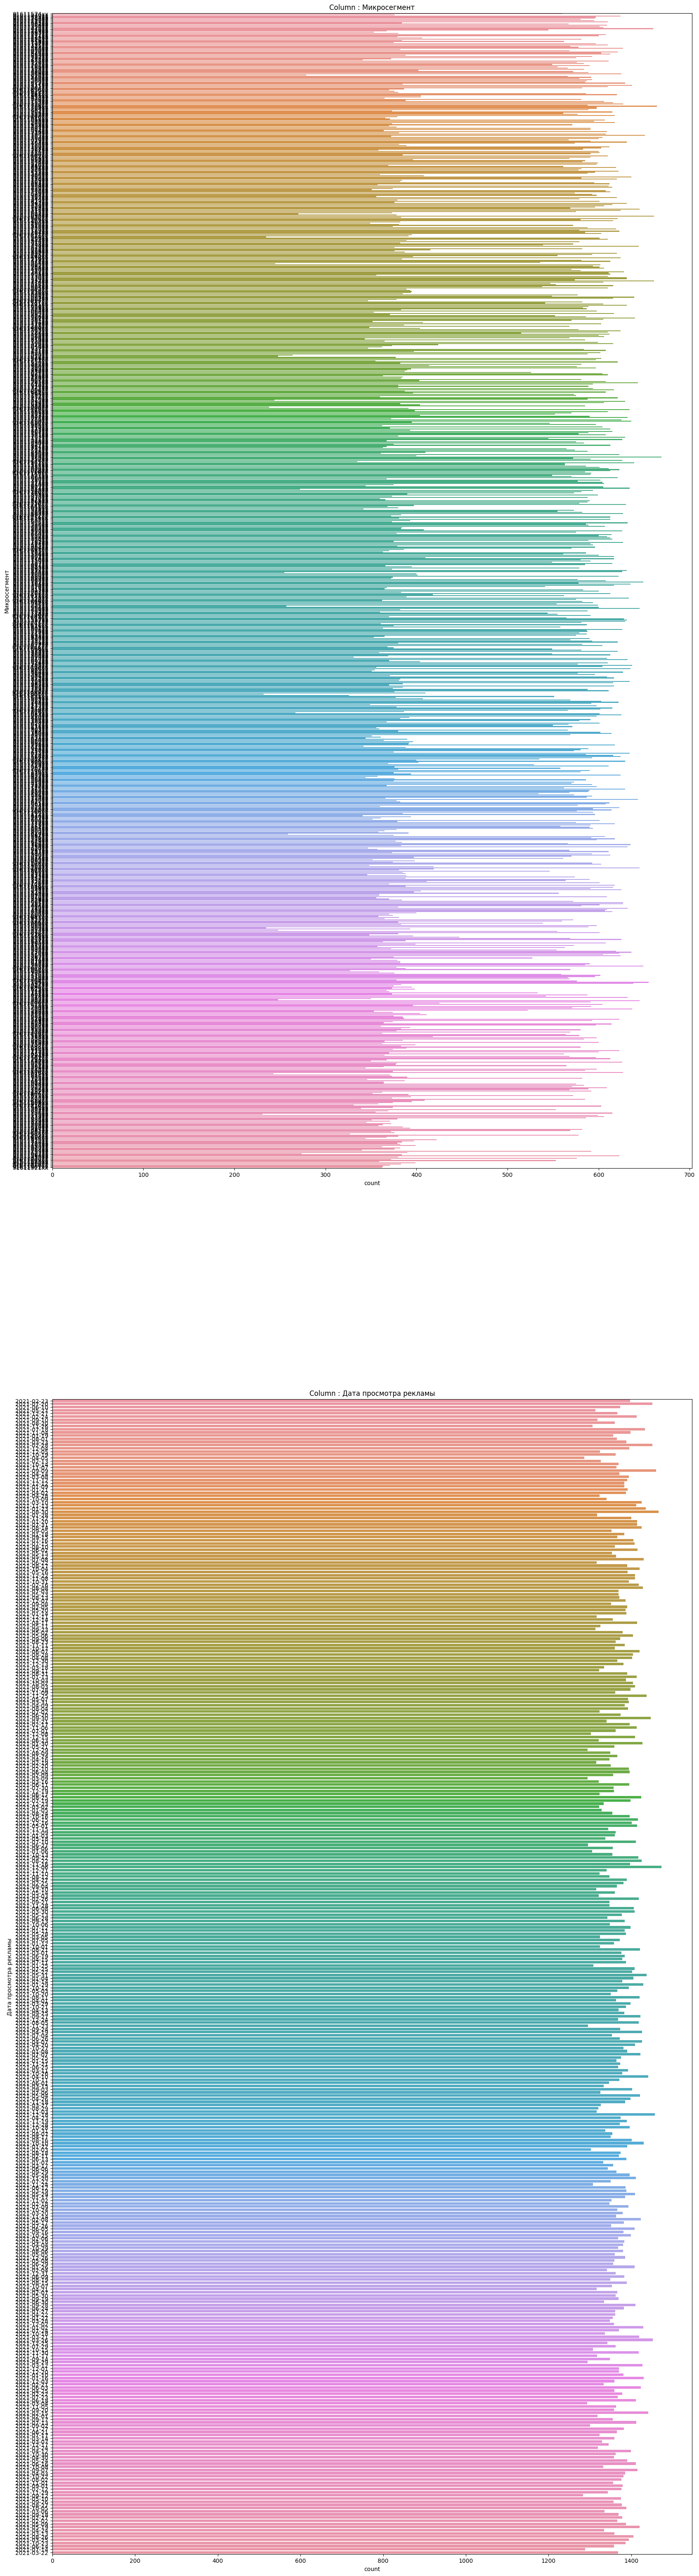

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

columns = QI

fig, ax = plt.subplots(len(columns), figsize = (20,80))
for i in range(len(columns)):
  ax[i].set_title('Column : ' + str(columns[i]))
  sns.countplot(y = columns[i], data = df, ax = ax[i])

#### Количество повторных значений

In [10]:
def quantity_qi(arg):
    quantity = Counter(df[arg])
    dic_quan = dict(quantity)
    
    for idx, item in enumerate(dic_quan.items(),1):
        if(arg == 'Микросегмент'):
            ws['A' + str(idx + 1)] = f"{item[0]}=>{item[1]}"
            ws['A1'] = f"{arg}"
        elif(arg == 'Дата просмотра рекламы'):
            ws['B' + str(idx + 1)] = f"{item[0]}=>{item[1]}"
            ws['B1'] = f"{arg}"

 #### Создается Excel файл, где в каждой ячейке после стрелочки выводиться количество повторов “имени” ячейки в исходном датасете.

In [11]:
wb = Workbook()
ws = wb.create_sheet("B1")
del wb['Sheet']
for arg in QI:
    quantity_qi(arg)
wb.save('quantity.xlsx')
df2 = pd.read_excel('quantity.xlsx', sheet_name="B1", engine = 'openpyxl')
df2.head(10)

,Микросегмент,Дата просмотра рекламы
0,91611574xx=>560,2021-02-23=>1397
1,91611870xx=>376,2021-07-20=>1451
2,91611395xx=>624,2021-06-10=>1373
3,91611534xx=>597,2021-05-27=>1313
4,91611261xx=>596,2021-12-27=>1366
5,91611190xx=>580,2021-02-24=>1413
6,91611271xx=>595,2021-09-10=>1318
7,91611583xx=>610,2021-08-20=>1360
8,91611932xx=>384,2021-11-26=>1306
9,91611302xx=>567,2021-07-18=>1433
